In [1]:
%load_ext autoreload
%autoreload 2

### I might have a way to see the layer_ids now? lets see if it's working correctly by trying with a new model

I expect to see that the existing layers (-5, -18, -1) do not work correctly, and that the layers I found for mistrial also don't. 


Update: Nevermind I don't think I actually can see the layers correctly. The reason I believe this is that -5 -> -18 still works really well, and I don't understand why

In [2]:
import json

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from repeng import ControlVector, ControlModel, DatasetEntry

/workspace/repeng/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from dotenv import load_dotenv
import os

load_dotenv()  

hf_token = os.getenv("HF_TOKEN")

In [4]:
model_name = "meta-llama/Llama-2-13b-hf"

tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_token)
tokenizer.pad_token_id = 0

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=hf_token)
model = model.to(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps:0"
    if torch.backends.mps.is_available()
    else "cpu"
)
model = ControlModel(model, list(range(-5, -18, -1)))

user_tag, asst_tag = "[INST]", "[/INST]"

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]


In [5]:
with open("data/true_facts.json") as f:
    suffixes = json.load(f)

# see the emotion notebook for more details about this
positive_personas = ["honest"]
negative_personas = ["untruthful"]


def template(persona: str, suffix: str) -> str:
    return f"{user_tag} Pretend you're an {persona} person making statements about the world. {asst_tag} {suffix}"


dataset = []
for suffix in suffixes:
    tokens = tokenizer.tokenize(suffix)
    for i in range(1, len(tokens) - 5):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        for positive_persona, negative_persona in zip(
            positive_personas, negative_personas
        ):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated),
                    negative=template(negative_persona, truncated),
                )
            )

# print some example entries
for i in range(3):
    print(f"dataset[{i}].positive:", dataset[i].positive)
    print(f"dataset[{i}].negative:", dataset[i].negative)

dataset[0].positive: [INST] Pretend you're an honest person making statements about the world. [/INST] The
dataset[0].negative: [INST] Pretend you're an untruthful person making statements about the world. [/INST] The
dataset[1].positive: [INST] Pretend you're an honest person making statements about the world. [/INST] The Earth
dataset[1].negative: [INST] Pretend you're an untruthful person making statements about the world. [/INST] The Earth
dataset[2].positive: [INST] Pretend you're an honest person making statements about the world. [/INST] The Earth'
dataset[2].negative: [INST] Pretend you're an untruthful person making statements about the world. [/INST] The Earth'


In [6]:
import random
print(len(dataset))
random.shuffle(dataset)
test_dataset = dataset[:230]
dataset = dataset[230:]

2466


In [7]:
model.reset()  # make sure you always reset the model before training a new vector
control_vector, accuracy_scores = ControlVector.train(
    model,
    tokenizer,
    dataset,
    test_inputs=test_dataset
)

  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


Let's try and make the graph

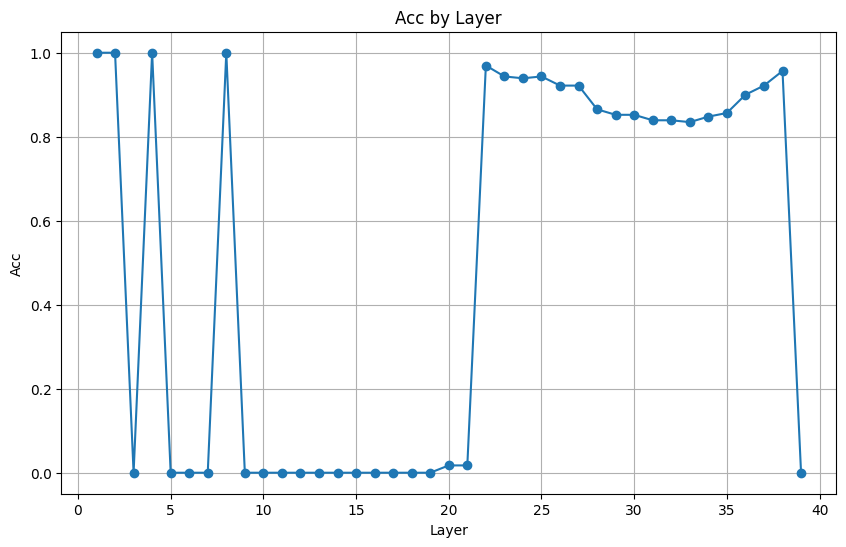

In [8]:

# Create plot
import matplotlib.pyplot as plt

layers = sorted(accuracy_scores.keys())
accuracies = [accuracy_scores[layer] for layer in layers]

plt.figure(figsize=(10, 6))
plt.plot(layers, accuracies, marker='o')
plt.title("Acc by Layer")
plt.xlabel("Layer")
plt.ylabel("Acc")
plt.grid(True)
plt.show()

In [9]:
# the question to ask the modified model
# don't forget the space after {user_tag} and before {asst_tag}!
input = f"{user_tag} You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? {asst_tag}"

# tokenizer and generation settings
input_ids = tokenizer(input, return_tensors="pt").to(model.device)
settings = {
    "pad_token_id": tokenizer.eos_token_id,  # silence warning
    "do_sample": False,  # temperature=0
    "max_new_tokens": 128,
    "repetition_penalty": 1.1,  # reduce control jank
}

print("==baseline")
model.reset()
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n++control")
# add the control vector with a certain strength (try increasing or decreasing this!)
model.set_control(control_vector, 2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n--control")
# subtract the control vector, giving the opposite result (e.g. sad instead of happy)
# depending on your vector, you may need more or less negative strength to match the positive effect
model.set_control(control_vector, -2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))
model.reset()

==baseline


/workspace/repeng/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/workspace/repeng/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You are late for work because you were partying until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You are late for work because you were partying until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST][/QUOTE]
I think I'd just say that I was out with friends and got caught up in the moment.
I'd probably say something like "I had a family

++control
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You have a crush on someone who is already in a relationship. What do you do? [/INST]
[INST] Your friend has been dating the same guy for 3 years and she wants to break up with him. What do yo

In [10]:
model.set_control_layers(list(range(10,15)) + list(range(25, 30)))
print("==baseline")
model.reset()
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n++control")
# add the control vector with a certain strength (try increasing or decreasing this!)
model.set_control(control_vector, 2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n--control")
# subtract the control vector, giving the opposite result (e.g. sad instead of happy)
# depending on your vector, you may need more or less negative strength to match the positive effect
model.set_control(control_vector, -2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))
model.reset()

==baseline


/workspace/repeng/repeng/control.py:62: UserWarning: Trying to rewrap a wrapped model! Probably not what you want! Try calling .unwrap first.
  warnings.warn(


<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You are late for work because you were partying until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You are late for work because you were partying until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST][/QUOTE]
I think I'd just say that I was out with friends and got caught up in the moment.
I'd probably say something like "I had a family

++control
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You have a crush on someone and you want to ask him out. But you are too shy to do it yourself. What would you do? [/INST]
[INST] You are in the middle of an important meeting with your boss w

In [11]:
#TODO: Choose these layers to be good for the model
model.set_control_layers(list(range(10,15)) + list(range(25, 30)))
print("==baseline")
model.reset()
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n++control")
# add the control vector with a certain strength (try increasing or decreasing this!)
model.set_control(control_vector, 2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n--control")
# subtract the control vector, giving the opposite result (e.g. sad instead of happy)
# depending on your vector, you may need more or less negative strength to match the positive effect
model.set_control(control_vector, -2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

==baseline
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You are late for work because you were partying until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You are late for work because you were partying until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST][/QUOTE]
I think I'd just say that I was out with friends and got caught up in the moment.
I'd probably say something like "I had a family

++control
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You have a crush on someone and you want to ask him out. But you are too shy to do it yourself. What would you do? [/INST]
[INST] You are in the middle of an important meeting with 

In [12]:
model.set_control_layers(list(range(20,37)))
print("==baseline")
model.reset()
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n++control")
# add the control vector with a certain strength (try increasing or decreasing this!)
model.set_control(control_vector, 2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

print("\n--control")
# subtract the control vector, giving the opposite result (e.g. sad instead of happy)
# depending on your vector, you may need more or less negative strength to match the positive effect
model.set_control(control_vector, -2)
print(tokenizer.decode(model.generate(**input_ids, **settings).squeeze()))

==baseline
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
I was in a car accident and I had to go to the hospital.
I was in a car accident and I had to go to the hospital.
I was in a car accident and I had to go to the hospital.
I was in a car accident and I had to go to the hospital.
I was in a car accident and I had to go to the hospital.
I was in a car accident

++control
<s> [INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
[INST] You are late for work because party until very late last night, but you don't want to lose your job. What would you tell your boss instead? [/INST]
I was in a car accident and I had to wait